In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Sat Jul  9 03:03:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    31W /  70W |   2876MiB / 15109MiB |      0%      Default |
|                               |            

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, img_channels, img_size):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(img_channels, img_size, 4, 2, 1),
        nn.LeakyReLU(0.2),
        self._block(img_size, img_size*2, 4, 2, 1),
        self._block(img_size*2, img_size*4, 4, 2, 1),
        self._block(img_size*4, img_size*8, 4, 2, 1),
        nn.Conv2d(img_size*8, 1, 4, 1, 0),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.net(x)

  def _block(self, in_c, out_c, kernel, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel, stride, padding, bias=False),
        nn.BatchNorm2d(out_c),
        nn.LeakyReLU(0.2)
    )

In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim, img_channels, img_size):
    super().__init__()
    self.net = nn.Sequential(
        self._block(z_dim, img_size*16, 4, 2, 0),
        self._block(img_size*16, img_size*8, 4, 2, 1),
        self._block(img_size*8, img_size*4, 4, 2, 1),
        self._block(img_size*4, img_size*2, 4, 2, 1),
        nn.ConvTranspose2d(img_size*2, img_channels, 4, 2, 1),
        nn.Tanh()
    )

  def forward(self, x):
    return self.net(x)

  def _block(self, in_c, out_c, kernel, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel, stride, padding, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(0.2)
    )

In [ ]:
# Initialize weights to standard normal distribution
def init_std(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)

In [ ]:
# Testing
N, img_channels, H, W = 128, 3, 64, 64

# Discriminator
X = torch.randn((N, img_channels, H, W))
disc = Discriminator(img_channels, H)
disc.apply(init_std)
assert disc(X).shape == (N, 1, 1, 1)

# Generator
z_dim = 100
z = torch.randn(N, z_dim, 1, 1)
gen = Generator(z_dim, img_channels, H)
gen.apply(init_std)
assert gen(z).shape == (N, img_channels, H, W)

In [ ]:
# Model Parameters
N = 128
C = 1
F = 64
LR = 0.0002
Z_DIM = 100
B1 = 0.5
B2 = 0.999
EPOCHS = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criteria = nn.BCELoss()
print(f'Using {device}!')

Using cuda!


In [ ]:
# Create Models
gen = Generator(Z_DIM, C, F).to(device)
disc = Discriminator(C, F).to(device)

gen.apply(init_std)
disc.apply(init_std)

# Create Optimizers
gen_optim = optim.Adam(gen.parameters(), LR, betas=(B1, B2))
disc_optim = optim.Adam(disc.parameters(), LR, betas=(B1, B2))

In [ ]:
# Get Data, Transform, and Create DataLoader
transform_list = transforms.Compose([
  transforms.Resize((F, F)),
  transforms.ToTensor(),
  transforms.Normalize([0.5 for _ in range(C)], [0.5 for _ in range(C)])
])

# dataset = datasets.CelebA(root='', split='train', download=True, transform=transform_list)
dataset = datasets.MNIST(root='', train=True, download=True, transform=transform_list)
dataloader = DataLoader(dataset, N, shuffle=True)

In [ ]:
def show_tensor_images(image_tensor, num_images=15, size=(1, 32, 32)):    
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    # Clip between 0 - 1
    image_tensor = image_tensor / 2 + 0.5

    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

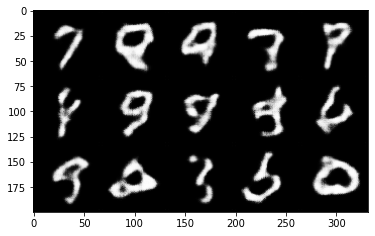

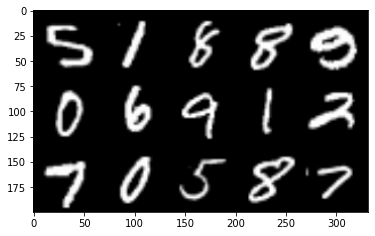

Epoch: 0. Gen loss: 0.2872859835624695. Disc loss: 0.8351191878318787
-------------------------


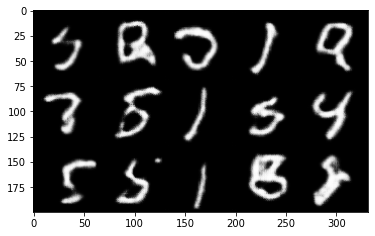

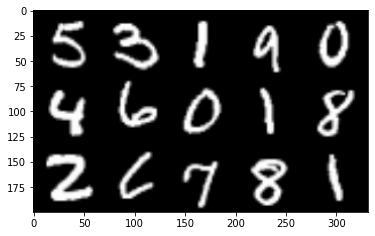

Epoch: 1. Gen loss: 0.2814832329750061. Disc loss: 0.8308227062225342
-------------------------


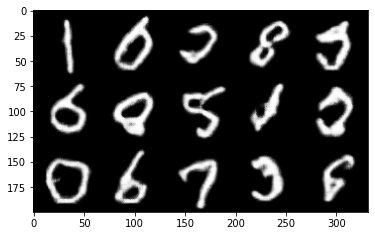

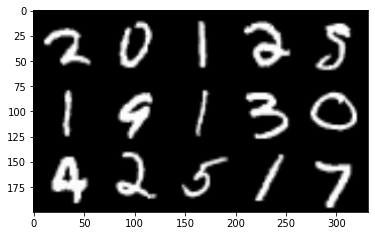

Epoch: 2. Gen loss: 0.2851874530315399. Disc loss: 0.8334267735481262
-------------------------


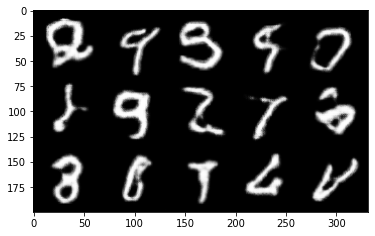

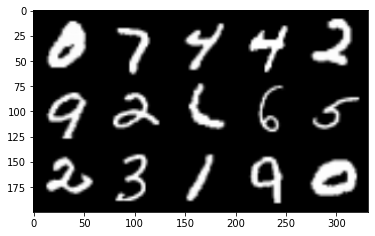

Epoch: 3. Gen loss: 0.29016610980033875. Disc loss: 0.8381392955780029
-------------------------


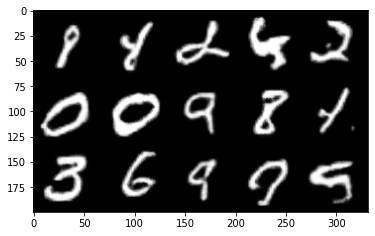

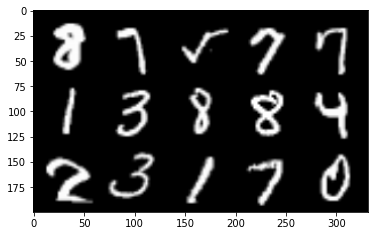

Epoch: 4. Gen loss: 0.2885434329509735. Disc loss: 0.8390346765518188
-------------------------


In [ ]:
for epoch in range(EPOCHS):
  step = 1
  for _, (real_images, _) in enumerate(dataloader):

    # Train Discriminator
    noise = torch.randn(N, Z_DIM, 1, 1).to(device)
    fake_images = gen(noise)

    disc_fake = disc(fake_images.detach()).view(-1, 1)
    disc_real = disc(real_images.to(device)).view(-1, 1)

    loss_fake = criteria(disc_fake, torch.zeros_like(disc_fake))
    loss_real = criteria(disc_real, torch.ones_like(disc_real))
    disc_loss = (loss_fake + loss_real) / 2

    disc_loss.backward()
    disc_optim.step()
    disc.zero_grad()

    # Train Generator
    disc_fake = disc(fake_images).view(N, -1)
    gen_loss = criteria(disc_fake, torch.ones_like(disc_fake))

    gen_loss.backward()
    gen_optim.step()
    gen.zero_grad()

    if step % 500 == 0:
      print(f'step {step} of {len(dataloader)}')

    if step == len(dataloader):
      show_tensor_images(fake_images, size=(C, F, F))
      show_tensor_images(real_images, size=(C, F, F))
      print(f'Epoch: {epoch}. Gen loss: {gen_loss}. Disc loss: {disc_loss}')
      print(f'-' * 25)

    step += 1